### MobileNet V1

#### Depthwise Separable Convolution
MobileNetは通常のConvolutionをDepthwise ConvolutionとPointwise Convolutionに分解したもの(depthwise separable convolution)が基本となり構成されます。
分解することで計算コストを削減することができます。

#### depthwise convolution
チャンネルごとに異なるフィルタで畳み込み処理を行います。

#### pointwise convolution
1×1の畳み込み処理を行います。

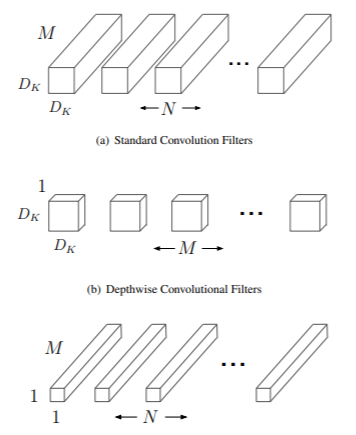

#### 構造

構造の詳細を次の表に示します。
depthwise convolutionとpointwise convolutionの組み合わせが基本単位ですが、下の図の右側で示すように各conv層の後にはBatchNormalizationとReLUが挿入されます。

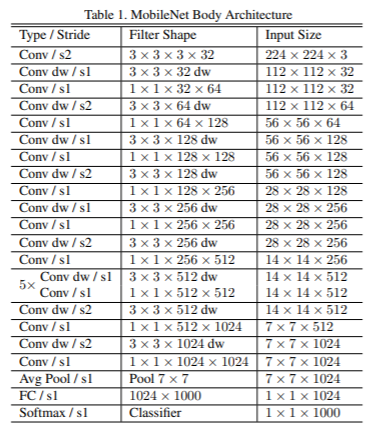

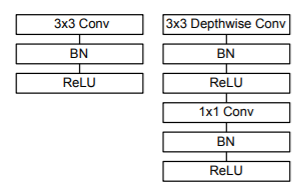


#### 学習
RMSPropを使用し、decayは0.9、$\epsilon$は1.0です。  
学習率は0.045で、2エポックごとにrateを0.94として指数的に減衰させていきます。  

In [34]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import cv2

In [5]:
class Depthwise_Separable_convolutions(Model):
    def __init__(self, out_channels, strides):
        super().__init__()
        self.conv_dw = DepthwiseConv2D(kernel_size = (3,3), strides=strides, padding = 'same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation('relu')
        
        self.conv_pw = Conv2D(filters = out_channels, kernel_size = (1,1), padding = 'same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation('relu')
    
    def call(self, x):
        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [12]:
class MobileNetV1(Model):
    def __init__(self):
        super().__init__()
        
        self.conv1 = Conv2D(32, kernel_size=3, strides=2, padding='same')
        self.DSconv1 = Depthwise_Separable_convolutions(out_channels=64, strides=1)
        self.DSconv2 = Depthwise_Separable_convolutions(out_channels=128, strides=2)
        self.DSconv3 = Depthwise_Separable_convolutions(out_channels=128, strides=1)
        self.DSconv4 = Depthwise_Separable_convolutions(out_channels=256, strides=2)
        self.DSconv5 = Depthwise_Separable_convolutions(out_channels=256, strides=1)
        self.DSconv6 = Depthwise_Separable_convolutions(out_channels=512, strides=2)
        self.DSconv7 = Sequential([Depthwise_Separable_convolutions(out_channels=512, strides=1) for _ in range(5)])
        self.DSconv8 = Depthwise_Separable_convolutions(out_channels=1024, strides=2)
        self.DSconv9 = Depthwise_Separable_convolutions(out_channels=1024, strides=1)
        
        self.pool = GlobalAveragePooling2D()
        self.fc = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.DSconv1(x)
        x = self.DSconv2(x)
        x = self.DSconv3(x)
        x = self.DSconv4(x)
        x = self.DSconv5(x)
        x = self.DSconv6(x)
        x = self.DSconv7(x)
        x = self.DSconv8(x)
        x = self.DSconv9(x)
        
        x = self.pool(x)
        x = self.fc(x)
        return x

In [13]:
model = MobileNetV1()
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 112, 112, 32)      896       
_________________________________________________________________
depthwise__separable_convolu (None, 112, 112, 64)      2816      
_________________________________________________________________
depthwise__separable_convolu (None, 56, 56, 128)       9728      
_________________________________________________________________
depthwise__separable_convolu (None, 56, 56, 128)       18816     
_________________________________________________________________
depthwise__separable_convolu (None, 28, 28, 256)       35840     
_________________________________________________________________
depthwise__separable_convolu (None, 28, 28, 256)      

In [ ]:
epochs = 100
initial_lrate = 0.0045

def decay(epoch, steps=100):
    initial_lrate = 0.0045
    drop = 0.94
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=0.045, rho=0.9, epsilon=1.0, decay=0.9)

lr_sc = LearningRateScheduler(decay, verbose=1)

model = MobileNetV1()
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [55]:
from keras.applications.mobilenet import MobileNet

input_shape = (224,224,3)
num_classes = 10

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[:87]:
    layer.trainable = False

In [54]:
model.layers

In [51]:
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)    

conv_pw_9_bn (BatchNormaliza (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_9_relu (ReLU)        (None, 14, 14, 512)       0         
_________________________________________________________________
conv_dw_10 (DepthwiseConv2D) (None, 14, 14, 512)       4608      
_________________________________________________________________
conv_dw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_pw_10 (Conv2D)          (None, 14, 14, 512)       262144    
_________________________________________________________________
conv_pw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_10_relu (ReLU)       (None, 14, 14, 512)       0         
__________

In [47]:
epochs = 100
initial_lrate = 0.0045

def decay(epoch, steps=100):
    initial_lrate = 0.0045
    drop = 0.94
    epochs_drop = 2
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=0.045, rho=0.9, epsilon=1.0, decay=0.9)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [22]:
class Depthwise_Separable_convolutions(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv_dw = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size = (3,3), stride=stride, groups=in_channels, padding = 1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=False)
        
        self.conv_pw = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = (1,1), padding = 'same')
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=False)
    
    def forward(self, x):
        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [27]:
class MobileNetV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.DSconv1 = Depthwise_Separable_convolutions(in_channels=32, out_channels=64, stride=1)
        self.DSconv2 = Depthwise_Separable_convolutions(in_channels=64, out_channels=128, stride=2)
        self.DSconv3 = Depthwise_Separable_convolutions(in_channels=128, out_channels=128, stride=1)
        self.DSconv4 = Depthwise_Separable_convolutions(in_channels=128, out_channels=256, stride=2)
        self.DSconv5 = Depthwise_Separable_convolutions(in_channels=256, out_channels=256, stride=1)
        self.DSconv6 = Depthwise_Separable_convolutions(in_channels=256, out_channels=512, stride=2)
        self.DSconv7 = nn.Sequential(*[Depthwise_Separable_convolutions(in_channels=512, out_channels=512, stride=1) for _ in range(5)])
        self.DSconv8 = Depthwise_Separable_convolutions(in_channels=512, out_channels=1024, stride=2)
        self.DSconv9 = Depthwise_Separable_convolutions(in_channels=1024, out_channels=1024, stride=1)
        
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.DSconv1(x)
        x = self.DSconv2(x)
        x = self.DSconv3(x)
        x = self.DSconv4(x)
        x = self.DSconv5(x)
        x = self.DSconv6(x)
        x = self.DSconv7(x)
        x = self.DSconv8(x)
        x = self.DSconv9(x)
        
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [28]:
from torchsummary import summary

summary(MobileNetV1(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
            Conv2d-2         [-1, 32, 112, 112]             320
       BatchNorm2d-3         [-1, 32, 112, 112]              64
              ReLU-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           2,112
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
Depthwise_Separable_convolutions-8         [-1, 64, 112, 112]               0
            Conv2d-9           [-1, 64, 56, 56]             640
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12          [-1, 128, 56, 56]           8,320
      BatchNorm2d-13          [-1, 128, 56, 56]             256
             ReLU-14     

In [ ]:
class MobileNetV1Trainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MobileNetV1()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.parameters(), lr=0.045, eps=1.0, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.06)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}